In [1]:
import sys
from pathlib import Path
import functools

import mujoco
from brax import envs
import jax
import jax.numpy as jp

from envs import register_ahac_anymal
from shac.brax_wrappers import AppendObsHistory

import shac.networks as shac_networks
# import shac.train as  shac
from shac.train_class import SHAC

In [2]:
env_name = 'ahac_anymal'

log_sigma = None
make_networks_factory = functools.partial(
    shac_networks.make_shac_networks,
        policy_hidden_layer_sizes=(256, 128),
        value_hidden_layer_sizes =(256, 128),
        scalar_var=False,
        layer_norm=True)

In [3]:
# Debugging params
num_grad_checks = None
save_all_policy_gradients = True

# Training Parameters
num_epochs = 500
num_evals = num_epochs + 1
unroll_length = 3 # Somewhat learns at 1. Doesn't at 8. Blows up at 16.
num_envs = 64

num_timesteps = (num_envs*unroll_length)*num_epochs

num_critic_minibatches = 4
num_critic_data = num_envs*unroll_length
critic_batch_size = num_critic_data / num_critic_minibatches

episode_length = 1000

polgrad_thresh = 1e6

# Environment Parameters
env_kwargs = {
    "s_afilt_buf" : 1,
    "train_standing" : False,
    "termination_height" : 0.15,
    "phys_step" : 10,
    "model_variant" : "anymal"
}

h = 5 # The number of history steps.

In [4]:
# Warning: takes 40s
# env      = AppendObsHistory(envs.get_environment(env_name, **env_kwargs), h=h)
# eval_env = AppendObsHistory(envs.get_environment(env_name, **env_kwargs), h=h)
env = envs.get_environment(env_name, **env_kwargs)
eval_env = envs.get_environment(env_name, **env_kwargs)

In [5]:
# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)


In [6]:
# state = jit_reset(jax.random.PRNGKey(0))
# state.obs
# state = jit_step(state, -1*jp.ones(1))
# state.obs
# state = jit_step(state, -1*jp.ones(1))
# state.obs

# state.obs.shape

In [7]:
# state.info['reward_tuple']

In [8]:
kwargs = dict( 
  num_timesteps=num_timesteps, log_sigma=log_sigma,
  num_evals=num_evals, use_tbx=True, tbx_logdir=f'{env_name}_log',
  tbx_experiment_name="obs_hist_unroll8", reward_scaling=1, 
  num_eval_envs = 64, num_envs=num_envs,
  unroll_length=unroll_length, critic_batch_size=critic_batch_size,
  critic_epochs = 16,target_critic_alpha = 0.2,
  discounting = 0.99, lambda_ = 0.95,
  normalize_observations=True,
  episode_length=episode_length, 
  network_factory = make_networks_factory, 
  seed=0, entropy_cost = 1e-3,
  resample_init=True,
  scramble_initial_times=True,
  num_grad_checks=num_grad_checks,
  save_all_checkpoints=True,
  polgrad_thresh=polgrad_thresh,
  save_all_policy_gradients=save_all_policy_gradients
  )

trainer = SHAC(environment=env, eval_env=eval_env, **kwargs)

Env steps per training step: 192
Training steps per epoch: 1
Critic minibatches per critic epoch: 4


In [9]:
make_inference_fn, policy_params, value_params, _= trainer.train()

Initial eval time: 19.9933 s
Deleting old checkpoints!
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 0
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 1
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 2
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 3
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 4
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 5
Checkpointed for epoch 6
Checkpointed for epoch 7
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 8


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 9
Checkpointed for epoch 10
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 11
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 12
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 13
Checkpointed for epoch 14
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 15
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 16
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 17
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 18


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 19
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 20
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 21
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 22
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 23
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 24
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 25
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 26
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 27
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for

Checkpointed for epoch 29
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 30
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 31
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 32
Checkpointed for epoch 33
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 34
Checkpointed for epoch 35
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 36


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 37
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 38
Checkpointed for epoch 39
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 40
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 41
Checkpointed for epoch 42
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 43
Checkpointed for epoch 44
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 45
Checkpointed for epoch 46
Checkpointed for epoch 47
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 48
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 49
at mapped index 0: Gradient too large! Policy not updated (`ch

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 53
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 54
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 55
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 56
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 57
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 58
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 59
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 60
Checkpointed for epoch 61
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 62
at mapped index 0: Gradient too large! Policy not updated (`check

Checkpointed for epoch 65
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 66
Checkpointed for epoch 67
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 68
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 69
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 70
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 71
Checkpointed for epoch 72


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 73
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 74
Checkpointed for epoch 75
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 76
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 77
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 78
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 79
Checkpointed for epoch 80
Checkpointed for epoch 81
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 82
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 83
Checkpointed for epoch 84


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 85
Checkpointed for epoch 86
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 87
Checkpointed for epoch 88
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 89
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 90
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 91
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 92
Checkpointed for epoch 93
Checkpointed for epoch 94
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 95
Checkpointed for epoch 96
Checkpointed for epoch 97
Checkpointed for epoch 98
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 99
at mapped 

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 123
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 124
Checkpointed for epoch 125
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 126
Checkpointed for epoch 127
Checkpointed for epoch 128
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 129
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 130
Checkpointed for epoch 131
Checkpointed for epoch 132
Checkpointed for epoch 133
Checkpointed for epoch 134
Checkpointed for epoch 135
Checkpointed for epoch 136
Checkpointed for epoch 137
Checkpointed for epoch 138
Checkpointed for epoch 139
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 140
Checkpointed for epoch 141
at mapped index 0: Gradient too large

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 181
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 182


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 183
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 184
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 185
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 186
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 187
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 188
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 189
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 190
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 191
Checkpointed for epoch 192


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 193
Checkpointed for epoch 194
Checkpointed for epoch 195
Checkpointed for epoch 196
Checkpointed for epoch 197
Checkpointed for epoch 198
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 199
Checkpointed for epoch 200
Checkpointed for epoch 201
Checkpointed for epoch 202
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 203
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 204
Checkpointed for epoch 205
Checkpointed for epoch 206
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 207
Checkpointed for epoch 208
Checkpointed for epoch 209
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 210
Checkpointed for epoch 211
Checkpointed for epoch 212
at mapped 

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 215
Checkpointed for epoch 216
Checkpointed for epoch 217
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 218
Checkpointed for epoch 219
Checkpointed for epoch 220
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 221
Checkpointed for epoch 222
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 223
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 224


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 225
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 226
Checkpointed for epoch 227
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 228
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 229
Checkpointed for epoch 230
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 231
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 232
Checkpointed for epoch 233
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 234
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 235
Checkpointed for epoch 236
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
C

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 251
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 252
Checkpointed for epoch 253
Checkpointed for epoch 254
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 255
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 256
Checkpointed for epoch 257
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 258
Checkpointed for epoch 259
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 260
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 261
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 262
Checkpointed for epoch 263
Checkpointed for epoch 264
at mapped index 0: Gra

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 293
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 294
Checkpointed for epoch 295
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 296
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 297
Checkpointed for epoch 298
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 299
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 300
Checkpointed for epoch 301
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 302
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 303
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 304
a

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 327
Checkpointed for epoch 328
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 329
Checkpointed for epoch 330
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 331
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 332
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 333
Checkpointed for epoch 334
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 335
Checkpointed for epoch 336
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 337
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 338
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
C

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 347
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 348
Checkpointed for epoch 349
Checkpointed for epoch 350
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 351
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 352
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 353
Checkpointed for epoch 354
Checkpointed for epoch 355
Checkpointed for epoch 356
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 357
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 358
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 359
Checkpointed for epoch 360
Checkpointed for epoch

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 385
Checkpointed for epoch 386
Checkpointed for epoch 387
Checkpointed for epoch 388
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 389
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 390
Checkpointed for epoch 391
Checkpointed for epoch 392
Checkpointed for epoch 393
Checkpointed for epoch 394
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 395
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 396
Checkpointed for epoch 397
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 398
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 399
at mapped index 0: Gradient too large! Policy not updated (`check` fai

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 421
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 422
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 423
Checkpointed for epoch 424
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 425
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 426
Checkpointed for epoch 427
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 428
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 429
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 430
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 431
at mapped index 0: Gradient 

at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 435
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 436
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 437
Checkpointed for epoch 438


Checkpointed for epoch 439
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 440
Checkpointed for epoch 441
Checkpointed for epoch 442
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 443
Checkpointed for epoch 444
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 445
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 446
Checkpointed for epoch 447
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 448
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 449
Checkpointed for epoch 450


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 451
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 452
Checkpointed for epoch 453
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 454
Checkpointed for epoch 455
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 456


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 457
Checkpointed for epoch 458
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 459
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 460
Checkpointed for epoch 461
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 462
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 463
Checkpointed for epoch 464
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 465
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 466
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 467
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 468
C

Checkpointed for epoch 479
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 480


at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 481
Checkpointed for epoch 482
Checkpointed for epoch 483
Checkpointed for epoch 484
Checkpointed for epoch 485
Checkpointed for epoch 486
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 487
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 488
Checkpointed for epoch 489
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 490
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 491
Checkpointed for epoch 492
Checkpointed for epoch 493
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 494
Checkpointed for epoch 495
at mapped index 0: Gradient too large! Policy not updated (`check` failed)
Checkpointed for epoch 496
Checkpointed for epoch 497
at mapped index 

#### Eval

In [ ]:
# utils_path = Path(Path.cwd().parent,
#                   Path("benchmarks"),
#                   Path("quadruped_stability_studies"))
# sys.path.append(str(utils_path))

from jax_shac.utils.eval_utils import plot_jacobian_norms, visualize_rollout, plot_rews

In [ ]:
renderer = mujoco.Renderer(env.model)

In [ ]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# jit_inference_fn = jax.jit(make_inference_fn(policy_params))

rng = jax.random.key(141)
init_key, rollout_key, rng = jax.random.split(rng, 3)
s0 = jit_reset(init_key)

jit_inference_fn = jax.jit(make_inference_fn(policy_params))

In [ ]:
if False:
    def spoof_policy(_, rng):
        bb = jax.random.choice(rng, jp.array([-1, 1]), 
                            p=jp.array([0.9, 1]))
        return bb.reshape(1), {}
        # return 2*(jax.random.uniform(rng).reshape(1)-0.5), {}
    jit_inference_fn = jax.jit(spoof_policy)

In [ ]:
if True:
    """ 
    Nan gradients:
    - Not seen in forward-mode AD
    - Jacrev doesn't work
    - Unclear whether nan's in training come from user code or MJX
        - https://github.com/google-deepmind/mujoco/issues/1349
    """
    all_jacs, state_jacs, ctrl_jacs = plot_jacobian_norms(s0, rollout_key, env, jit_inference_fn,
                                                jit_step, episode_length=240,
                                                ret_jacs=True, jacmode='fwd')

TypeError: cannot reshape array of shape (12,) (size 12) into shape 1 (size 1)

In [ ]:
state_h, states = visualize_rollout(s0, rollout_key, env, 
                                    jit_inference_fn, jit_step, renderer, 
                                    episode_length=240, print_nans=False, 
                                    print_dones=True, ret_states=True, camera="track")

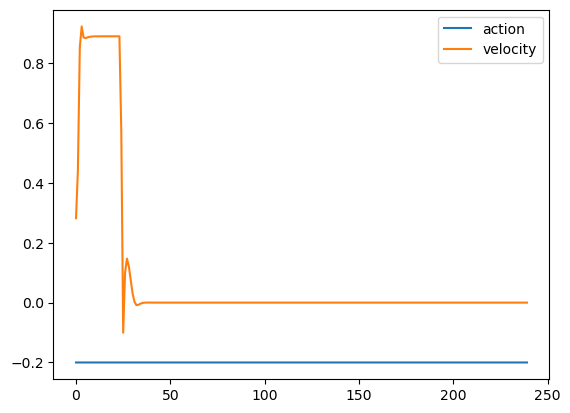

In [ ]:
rews = plot_rews(states)

## Debugging the Large Gradient Variance

#### Policy gradient sizes across enviroments

Text(0, 0.5, 'Log10 Policy gradient size')

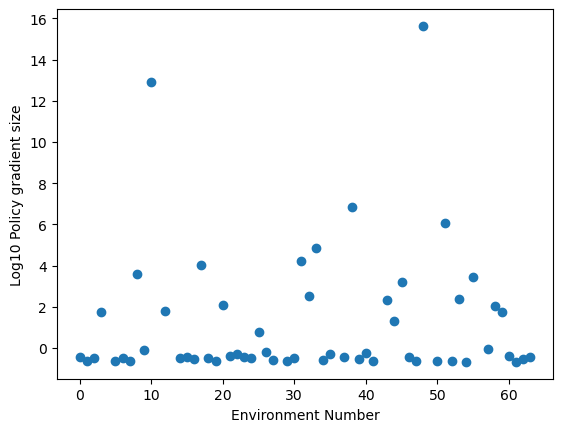

In [15]:
import matplotlib.pyplot as plt
import jax.numpy as jp
import pickle
import jax
import operator

it = 1 # Step 1 has gradients size 1e15.
# Load policy gradients
bgrad_path = f"/home/andrew/Documents/thesis/jax_shac/shac/policy_gradients/bgrad_{it}.pkl"
bgrad = pickle.load(open(bgrad_path, "rb"))

# Calculate the norm over the env axis for all leaves.
def norm(l, axes):
    ret = jp.square(l)
    ret = jp.mean(ret, axis=axes)
    ret = jp.sqrt(ret)
    return ret

reduced_leaves = jax.tree_util.tree_map(lambda l: norm(
    l, axes=(range(1, len(l.shape)))), bgrad)
pg_size_per_env = jax.tree.reduce(operator.add, reduced_leaves)

num_envs = 64
x_axis = jp.linspace(0, num_envs-1, num_envs)
plt.scatter(x_axis, jp.log10(pg_size_per_env))
plt.xlabel("Environment Number")
plt.ylabel("Log10 Policy gradient size")

In [7]:
jp.mean(pg_size_per_env)

Array(nan, dtype=float32)

#### Are large policy gradients caused by large mjx jacobians?

The answer: Sort of; small mjx jacobians don't result in large policy grads.

In [8]:
# Repeat the offending unroll
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, ts.normalizer_params,
                           state, key, unroll_length=32)
actions = extras["action"]
print(jacs.shape)

ValueError: vmap in_axes must be an int, None, or a tuple of entries corresponding to the positional arguments passed to the function, but got len(in_axes)=5, len(args)=4

In [9]:
jac_norms = norm(jacs, axes=(2, 3))
max_norm_per_env = jp.max(jac_norms, axis=1)

# Normalize both. 
# assert len(pg_size_per_env.shape) == 1
# assert len(max_norm_per_env.shape) == 1

# n_pg_size_per_env = pg_size_per_env / jp.linalg.norm(pg_size_per_env)
# n_max_norm_per_env = max_norm_per_env / jp.linalg.norm(max_norm_per_env)

# plt.plot(n_pg_size_per_env, label="Policy gradient size")
print("{} nan policy gradients and {} nan state gradients".format(
    jp.sum(jp.isnan(pg_size_per_env)),
    jp.sum(jp.isnan(max_norm_per_env))
))

# Also plot the nans
nan_inds = jp.argwhere(jp.isnan(pg_size_per_env))
nan_y = jp.ones(len(nan_inds)) * 20 # Just for visualization
plt.scatter(x_axis, jp.log10(pg_size_per_env) , label="Policy gradient size")
plt.scatter(x_axis, jp.log10(max_norm_per_env), label="Size of max rollout mjx jacobian")
plt.scatter(nan_inds, nan_y, label="Nan policy gradient")

plt.legend()

NameError: name 'jacs' is not defined

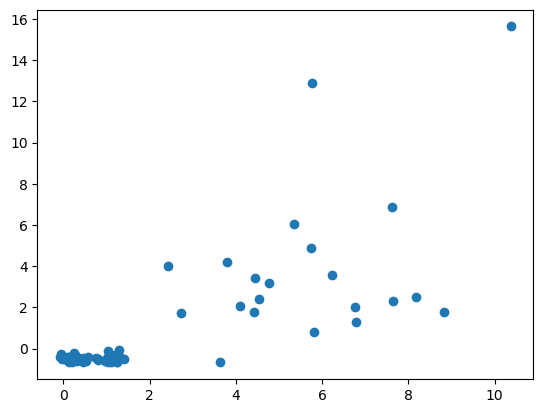

In [14]:
plt.scatter(jp.log10(max_norm_per_env), jp.log10(pg_size_per_env))

#### Do large jacobians occur uniformly randomly?

In [13]:
# Collect a rollout with a longer unroll length.
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

long_jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, ts.normalizer_params,
                           state, key, 32)

actions = extras["action"]
print(long_jacs.shape)

(64, 32, 37, 49)


In [17]:
jac_norms = norm(long_jacs, axes=(2, 3))
thresh = 100 # Based on above figure
big_jacs = jac_norms > thresh

plt.imshow(big_jacs)
plt.xlabel("Step")
plt.ylabel("Environment Index")

NameError: name 'norm' is not defined

#### State Space: what states result in large jacobians?

In [9]:
# Collect a long rollout
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']


In [10]:

# long_jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, 
#                                                  ts.normalizer_params,
#                                                  state, key, 32)

# actions = extras["action"]
# print(long_jacs.shape)

In [11]:

# import pickle
# pickle.dump(
#     (long_jacs, nstates),
#     open("/tmp/debugstates.pkl", "wb")
# )

In [12]:
import pickle
long_jacs, nstates = pickle.load(open("/tmp/debugstates.pkl", "rb"))

In [13]:
import mediapy as media
# Unbatch for env 1.
i_env = 1
def unvmap(tree, index):
    return jax.tree_util.tree_map(lambda x: x[index], tree)

rjacs = long_jacs[i_env]
rstate = unvmap(state, i_env)
rnstates = unvmap(nstates, i_env)

ims = trainer.render_states(rstate, rnstates, rjacs, 100)
media.show_video(ims, fps=1/trainer.env.dt)

Text(0, 0.5, 'Environment Index')

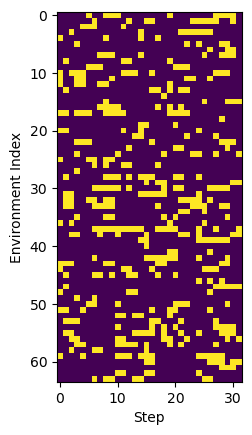

In [16]:
jac_norms = norm(long_jacs, axes=(2, 3))
thresh = 100 # Based on above figure
big_jacs = jac_norms > thresh
import matplotlib.pyplot as plt
plt.imshow(big_jacs)
plt.xlabel("Step")
plt.ylabel("Environment Index")

#### Gradients during Resets

Conclusion: 
- Confirmed that the jacobian norm is zero upon resetting. If s_k+1 is done, the state gets reset on the same timestep. Then, ds_k+1/ds_k = 0. 

In [9]:
import matplotlib.pyplot as plt
from jax_shac.utils.trainer_utils import norm

# Collect a long rollout
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

long_jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, 
                                                 ts.normalizer_params,
                                                 state, key, 32)

actions = extras["action"]

Text(0, 0.5, 'Jacobian norm')

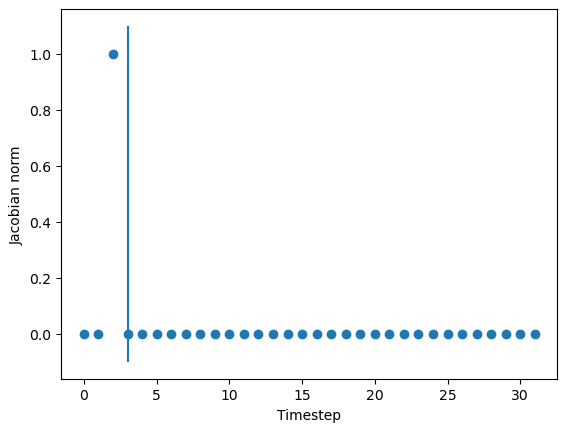

In [15]:
# Unbatch for env 1.
i_env = 13
def unvmap(tree, index):
    return jax.tree_util.tree_map(lambda x: x[index], tree)

rjacs = long_jacs[i_env]
rstate = unvmap(state, i_env)
rnstates = unvmap(nstates, i_env)

dones = jp.concatenate([jp.reshape(rstate.done, newshape=(1,)),
                        rnstates.done])[:-1] # d0 to d_{H-1}
dones = jp.argwhere(dones)

num_dones = len(dones)
plt.vlines(dones, -0.1 * jp.ones(num_dones), 1.1 * jp.ones(num_dones))

# where are the jacs 0?
rjacs = norm(rjacs, axes=(1, 2))
zjacs = rjacs == 0
x_axis = jp.linspace(0, len(zjacs)-1, len(zjacs))
plt.scatter(x_axis, zjacs)
plt.xlabel("Timestep")
plt.ylabel("Jacobian norm")


#### Which partial derivatives blow up?

In [ ]:
import matplotlib.pyplot as plt
from jax_shac.utils.trainer_utils import norm

# Collect a long rollout
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

long_jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, 
                                                 ts.normalizer_params,
                                                 state, key, 32)

actions = extras["action"]

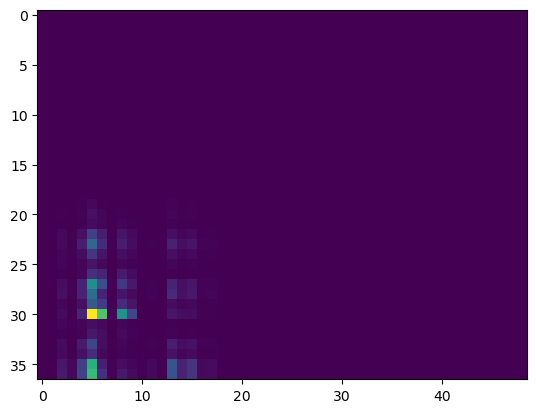

In [16]:
# Jacobian Space
a_jacs = jp.abs(long_jacs)
c_jacs = jp.mean(a_jacs, axis=(0, 1))
plt.imshow(c_jacs)

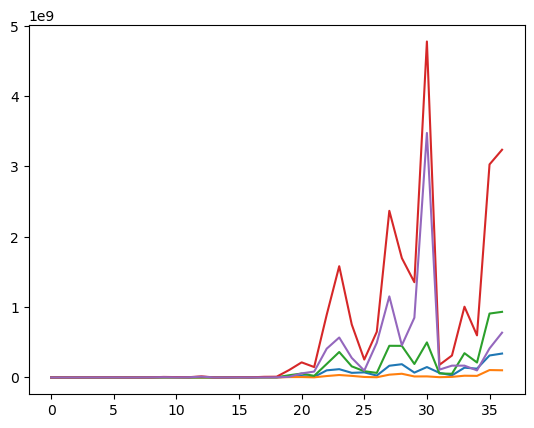

In [18]:
qdim = trainer.env.sys.nq
dqdim = trainer.env.sys.nv
adim = trainer.env.sys.nu

# Aggregate
dqdq = long_jacs[...,:qdim,: qdim]
adqdq = jp.mean(dqdq, axis=(2, 3))

# Flatten
adqdq = jp.ravel(adqdq)
plt.hist(adqdq)